In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('df.csv', index_col = 0)
labels = pd.read_csv('labels.csv', index_col = 0)
train, test, train_labels, test_labels = train_test_split(df, labels, train_size = 2000, test_size = 8000, random_state=0)

In [55]:
from torch.utils.data import Dataset, TensorDataset, DataLoader

class PurchaseDataset(Dataset):
    def __init__(self, x_tensor, y_tensor, n_labels):
        self.x = torch.tensor(x_tensor.values).float()
        self.y = torch.tensor(y_tensor[str(n_labels)].values).float()
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [56]:
train_dataset = PurchaseDataset(train, train_labels, 2)

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [58]:
def train_model(n_labels, epochs, batch_size, verbose=False):

    train_dataset = PurchaseDataset(train, train_labels, n_labels)
    test_dataset = PurchaseDataset(test, test_labels, n_labels)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

    input_dim = x_train_tensor.shape[1]
    output_dim = len(np.unique(y_train_tensor))
    
    # make model
    torch.manual_seed(0)
    class Net(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(Net, self).__init__()
            # an affine operation: y = Wx + b
            self.fc1 = nn.Linear(input_dim, 1024)
            self.fc2 = nn.Linear(1024, 1024)
            self.fc3 = nn.Linear(1024, 512)
            self.fc4 = nn.Linear(512, 512)
            self.fc5 = nn.Linear(512, 512)
            self.fc6 = nn.Linear(512, output_dim)
            self.softmax = nn.LogSoftmax(dim=-1)

        def forward(self, x):
            # Max pooling over a (2, 2) window
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            x = F.relu(self.fc4(x))
            x = F.relu(self.fc5(x))
            x = self.softmax(self.fc6(x))
            return x
    
    net = Net(input_dim, output_dim)
    net.to(device)
    
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(net.parameters())
    
    # train model
    running_loss = 0.0
    done_flag = False
    for epoch in range(epochs):  # loop over the dataset multiple times
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(x_batch)
            loss = criterion(outputs, y_batch.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if (epoch % 5 == 0):
            if running_loss < 0.001:
                if done_flag:
                    print("Terminated Early. 10 successive epochs all have 0 loss")
                    break
                else:
                    done_flag = True
                    if verbose:
                        print('[%d] loss: %.3f' % (epoch, running_loss / 5))
            else:
                if done_flag:
                    done_flag = not done_flag
                if verbose:
                    print('[%d] loss: %.3f' % (epoch, running_loss / 5))
                running_loss = 0.0

    print('Finished Training')
    
    return net

In [59]:
net_2 = train_model(n_labels=2, epochs=400, batch_size=512, verbose=False)
net_10 = train_model(n_labels=10, epochs=400, batch_size=512, verbose=False)
net_20 = train_model(n_labels=20, epochs=400, batch_size=512, verbose=False)
net_50 = train_model(n_labels=50, epochs=400, batch_size=512, verbose=False)
net_100 = train_model(n_labels=100, epochs=400, batch_size=512, verbose=False)

KeyboardInterrupt: 

In [9]:
def auc(model, train, test, sample_size):
    train_sample = train[np.random.choice(train.shape[0], size = sample_size)]
    test_sample = test[np.random.choice(test.shape[0], size = sample_size)]
    train_confidence = torch.max(torch.exp(model(torch.Tensor(train_sample).to(device)).detach()), axis=1)[0]
    test_confidence = torch.max(torch.exp(model(torch.Tensor(test_sample).to(device)).detach()), axis=1)[0]
    
    actual = [1 for i in range(sample_size)] + [0 for i in range(sample_size)]
    estimated = torch.cat([train_confidence, test_confidence])
    return roc_auc_score(torch.Tensor(actual), estimated.cpu())

auc_2 = auc(net_2, train, test, 1000)
auc_10 = auc(net_10, train, test, 1000)
auc_20 = auc(net_20, train, test, 1000)
auc_50 = auc(net_50, train, test, 1000)
auc_100 = auc(net_100, train, test, 1000)

print("Purchase Dataset")
print('      Paper   Us')
print('2   | 0.548 |', np.round(auc_2, 3))
print('10  | 0.628 |', np.round(auc_10, 3))
print('20  | 0.671 |', np.round(auc_20, 3))
print('50  | 0.745 |', np.round(auc_50, 3))
print('100 | 0.794 |', np.round(auc_100, 3))

#targets: 0.548, 0.628, 0.671, 0.745, 0.794 for Purchase-2, 10, 20, 50, 100 respectively

Purchase Dataset
      Paper   Us
2   | 0.548 | 0.582
10  | 0.628 | 0.813
20  | 0.671 | 0.854
50  | 0.745 | 0.924
100 | 0.794 | 0.943


In [3]:
# compute hamming distance from point to set
def ham_set(p, t):
  p = p.transpose()
  n1 = np.matmul(t, p)
  n0 = np.matmul(1 - t, 1 - p)
  return len(p) - np.amax(n1 + n0, axis=0)
distances = ham_set(test, train)

ValueError: Shape of passed values is (2000, 8000), indices imply (2000, 824)

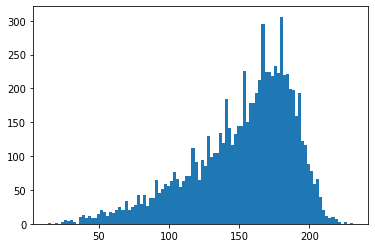

In [12]:
plt.hist(distances, bins = 100)
plt.show()

In [0]:
groups = {}
for (features, dist) in zip(test, distances):
  if dist not in groups.keys():
    groups[dist] = []
  groups[dist].append(features)

In [0]:
keys = sorted([key for key in groups.keys() if len(groups[key]) >= 10])
aucs_2 = [auc(net_2, train, np.array(groups[key]), 500) for key in keys]
aucs_10 = [auc(net_10, train, np.array(groups[key]), 500) for key in keys]
aucs_20 = [auc(net_20, train, np.array(groups[key]), 500) for key in keys]
aucs_50 = [auc(net_50, train, np.array(groups[key]), 500) for key in keys]
aucs_100 = [auc(net_100, train, np.array(groups[key]), 500) for key in keys]


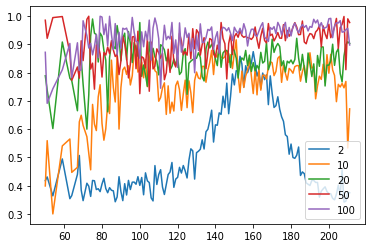

In [15]:
plt.plot(keys, aucs_2, label = "2")
plt.plot(keys, aucs_10, label = "10")
plt.plot(keys, aucs_20, label = "20")
plt.plot(keys, aucs_50, label = "50")
plt.plot(keys, aucs_100, label = "100")
plt.legend(loc = 'lower right')
plt.show()